# Detection of Intrusions in Networks using Various Tree Classifiers
***
Dataset Used - CICIDS2017 (https://www.unb.ca/cic/datasets/ids-2017.html)
***

## Importing Libraries

In [134]:
import numpy as np # Linear Algebra
import pandas as pd # CSV Data Processing
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization 
from sklearn.preprocessing import LabelEncoder # Preprocessing
from sklearn.model_selection import train_test_split # Preprocessing
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support # Evaluation
from sklearn.metrics import f1_score # Evaluation
from imblearn.over_sampling import SMOTE # Oversampling

from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier # Model
from sklearn.tree import DecisionTreeClassifier # Model
import xgboost as xgb # Model
from xgboost import plot_importance # Model
from sklearn.ensemble import GradientBoostingClassifier # Model

## Reading the Dataset

In [108]:
# Read Dataset
df = pd.read_csv('data/CICIDS2017_sample.csv')

In [109]:
df # Display Dataset

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [110]:
df.Label.value_counts() # Counting Occurrences

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

## Sampling the Dataset

In [111]:
# Majority Classes
df_BENIGN = df[(df['Label'] == 'BENIGN')]
df_DoS = df[(df['Label'] == 'DoS')]
df_PortScan = df[(df['Label'] == 'PortScan')]
df_BruteForce = df[(df['Label'] == 'BruteForce')]

# Randomly Sampling from Labels
df_minor = df[(df['Label'] == 'WebAttack') | (df['Label'] == 'Bot') | (df['Label'] == 'Infiltration')] # Minority Classes
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [112]:
df_s = pd.concat([df_BENIGN, df_DoS, df_PortScan, df_BruteForce, df_minor], ignore_index=True) # Merging Classes
df_s = df_s.sort_index() # Sorting Data

In [113]:
# Saving the Dataset
# df_s.to_csv('./data/CICIDS2017_sample.csv',index=0)

## Preprocessing (Normalization & Padding)

In [114]:
df = pd.read_csv('./data/CICIDS2017_sample.csv') # Read the Sampled Dataset

In [115]:
# Min-Max Normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(lambda x: (x - x.min()) / (x.max()-x.min()))

# Replace Empty Values with 0
df = df.fillna(0)

## Splitting Dataset (Training & Testing)

In [116]:
# Label Encoding
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

x = df.drop(['Label'], axis=1) # Features
y = df['Label'] # Labels

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y) # Splitting Dataset

In [117]:
x_train.shape # Shape of Training Data

(45328, 77)

In [118]:
pd.Series(y_train).value_counts() # Counting Occurrences

Label
0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

## Oversampling (SMOTE)

In [119]:
smote = SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Generating Samples for Minority Class "4"

In [120]:
# Shape of Dataset before Oversampling
print(x_train.shape)
print(y_train.shape)

(45328, 77)
(45328,)


In [121]:
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train) # Resampling the Data

In [122]:
pd.Series(y_train_resampled).value_counts() # Counting Occurrences

Label
0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
Name: count, dtype: int64

## Model Training

### Decision Tree

Accuracy of DT: 0.9960292949792641
Precision of DT: 0.9960304514616795
Recall of DT: 0.9960292949792641
F1-score of DT: 0.9960119038371011
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



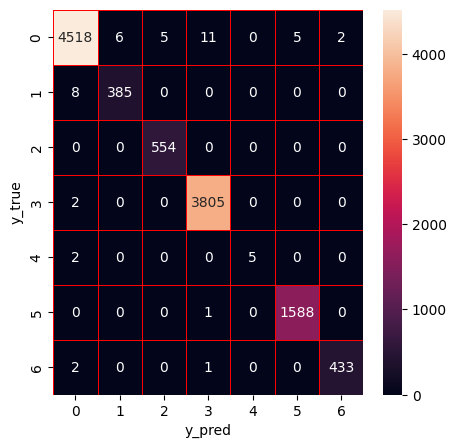

In [140]:
# Decision Tree Training
dt = DecisionTreeClassifier(random_state = 0) # Decision Tree Classifier
dt.fit(x_train_resampled,y_train_resampled) # Training
dt_score = dt.score(x_test,y_test) # Evaluation on Test Data
y_predict = dt.predict(x_test) # Predicting Test Data
y_true = y_test # True Labels for Test Data

print('Accuracy of DT: '+ str(dt_score)) # Accuracy of Model
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted') # Precision, Recall & F1-score of Model
print('Precision of DT: '+ (str(precision))) # Precision of the Model
print('Recall of DT: '+ (str(recall))) # Recall of the Model
print('F1-score of DT: '+ (str(fscore))) # F1-score of the Model

print(classification_report(y_true,y_predict)) # Classification Report of Model
cm = confusion_matrix(y_true,y_predict) # Confusion Matrix of Model
f, ax = plt.subplots(figsize=(5,5)) # Size of Confusion Matrix
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax) # Plot Confusion Matrix

plt.xlabel("y_pred") # Labels for x-axis
plt.ylabel("y_true") # Labels for y-axis
plt.show() # Shows Confusion Matrix

In [141]:
# Decision Tree Prediction
dt_train = dt.predict(x_train_resampled)  # Training data
dt_test = dt.predict(x_test)  # Test data

### Random Forest

Accuracy of RF: 0.9958528192005647
Precision of RF: 0.995852717659273
Recall of RF: 0.9958528192005647
F1-score of RF: 0.995826131600522
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4547
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



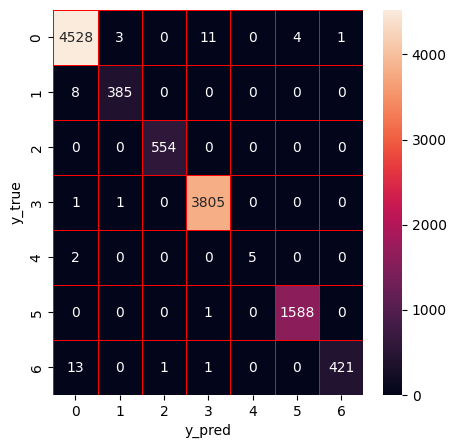

In [125]:
# Random Forest Training
rf = RandomForestClassifier(random_state = 0) # Random Forest Classifier
rf.fit(x_train_resampled,y_train_resampled) # Training
rf_score = rf.score(x_test,y_test) # Evaluation on Test Data
y_predict = rf.predict(x_test) # Predict Test Data
y_true = y_test # True Labels for Test Data

print('Accuracy of RF: '+ str(rf_score)) # Accuracy of Model
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted') # Precision, Recall, and F1-score of Model
print('Precision of RF: '+(str(precision))) # Precision of the Model
print('Recall of RF: '+(str(recall))) # Recall of the Model
print('F1-score of RF: '+(str(fscore))) # F1-score of the Model

print(classification_report(y_true,y_predict)) # Classification Report of Model
cm = confusion_matrix(y_true,y_predict) # Confusion Matrix of Model
f, ax = plt.subplots(figsize=(5,5)) # Size of Confusion Matrix
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax) # Plot Confusion Matrix

plt.xlabel("y_pred") # Labels for x-axis
plt.ylabel("y_true") # Labels for y-axis
plt.show() # Shows Confusion Matrix

In [126]:
# Random Forest Prediction
rf_train = rf.predict(x_train_resampled) # Training Data
rf_test = rf.predict(x_test) # Test Data

### Extra Trees

Accuracy of ET: 0.9924115415159269
Precision of ET: 0.9924242003899876
Recall of ET: 0.9924115415159269
F1-score of ET: 0.9923979162328536
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.98      0.97       393
           2       0.99      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.96      0.97       436

    accuracy                           0.99     11333
   macro avg       0.96      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



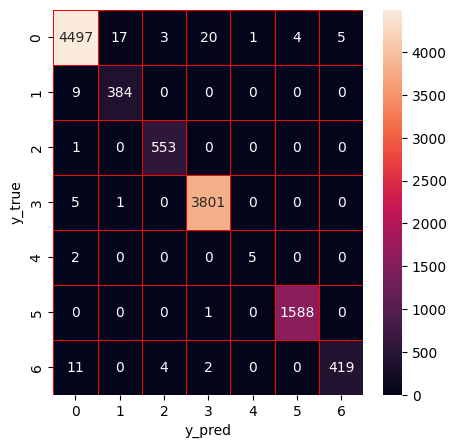

In [127]:
# Extra Trees Training
et = ExtraTreesClassifier(random_state = 0) # Extra Trees Classifier
et.fit(x_train_resampled,y_train_resampled) # Training
et_score = et.score(x_test,y_test) # Evaluation on Test Data
y_predict = et.predict(x_test) # Predict Test Data
y_true = y_test # True Labels for Test Data

print('Accuracy of ET: '+ str(et_score)) # Accuracy of Model
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted') # Precision, Recall, and F1-score of Model
print('Precision of ET: '+(str(precision))) # Precision of the Model
print('Recall of ET: '+(str(recall))) # Recall of the Model
print('F1-score of ET: '+(str(fscore))) # F1-score of the Model

print(classification_report(y_true,y_predict)) # Classification Report of Model
cm = confusion_matrix(y_true,y_predict) # Confusion Matrix of Model
f, ax = plt.subplots(figsize=(5,5)) # Size of Confusion Matrix
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax) # Plot Confusion Matrix

plt.xlabel("y_pred") # Labels for x-axis
plt.ylabel("y_true") # Labels for y-axis
plt.show() # Shows Confusion Matrix

In [128]:
# Extra Trees Prediction
et_train = et.predict(x_train_resampled) # Training Data
et_test = et.predict(x_test) # Test Data

### XGBoost

Accuracy of XG: 0.9942645371922704
Precision of XG: 0.9942570531517144
Recall of XG: 0.9942645371922704
F1-score of XG: 0.9942434544720865
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.96      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



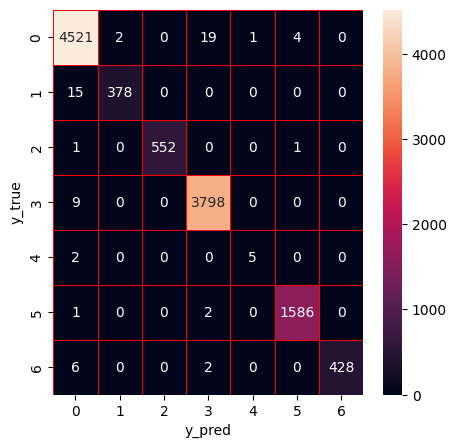

In [129]:
# XGBoost Training
xg = xgb.XGBClassifier(n_estimators = 10) # XGBoost Classifier
xg.fit(x_train_resampled,y_train_resampled) # Training
xg_score = xg.score(x_test,y_test) # Evaluation on Test Data
y_predict = xg.predict(x_test) # Predict Test Data
y_true = y_test # True Labels for Test Data

print('Accuracy of XG: '+ str(xg_score)) # Accuracy of Model
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted') # Precision, Recall, and F1-score of Model
print('Precision of XG: '+(str(precision))) # Precision of the Model
print('Recall of XG: '+(str(recall))) # Recall of the Model
print('F1-score of XG: '+(str(fscore))) # F1-score of the Model

print(classification_report(y_true,y_predict)) # Classification Report of Model
cm = confusion_matrix(y_true,y_predict) # Confusion Matrix of Model
f, ax = plt.subplots(figsize=(5,5)) # Size of Confusion Matrix
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax) # Plot Confusion Matrix

plt.xlabel("y_pred") # Labels for x-axis
plt.ylabel("y_true") # Labels for y-axis
plt.show() # Shows Confusion Matrix

In [130]:
# XGBoost Prediction
xg_train = xg.predict(x_train_resampled) # Training Data
xg_test = xg.predict(x_test) # Test Data

### GBM

Accuracy of GBM: 0.9224388952616254
Precision of GBM: 0.928121957029897
Recall of GBM: 0.9224388952616254
F1-score of GBM: 0.9232315691068737
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      4547
           1       0.79      0.62      0.69       393
           2       0.85      0.99      0.91       554
           3       0.94      0.99      0.97      3807
           4       0.14      0.71      0.23         7
           5       0.99      0.99      0.99      1589
           6       0.62      0.82      0.71       436

    accuracy                           0.92     11333
   macro avg       0.75      0.86      0.77     11333
weighted avg       0.93      0.92      0.92     11333



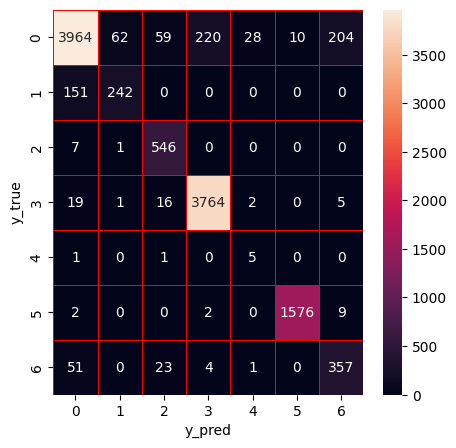

In [144]:
# GBM Training
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0) # GBM classifier
gbm.fit(x_train_resampled,y_train_resampled) # Training
gbm_score = gbm.score(x_test,y_test) # Evaluation on Test Data
y_predict = gbm.predict(x_test) # Predict Test Data
y_true = y_test # True Labels for Test Data

print('Accuracy of GBM: '+ str(gbm_score)) # Accuracy of Model
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted') # Precision, Recall, and F1-score of Model
print('Precision of GBM: '+(str(precision))) # Precision of the Model
print('Recall of GBM: '+(str(recall))) # Recall of the Model
print('F1-score of GBM: '+(str(fscore))) # F1-score of the Model

print(classification_report(y_true,y_predict)) # Classification Report of Model
cm = confusion_matrix(y_true,y_predict) # Confusion Matrix of Model
f, ax = plt.subplots(figsize=(5,5)) # Size of Confusion Matrix
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax) # Plot Confusion Matrix

plt.xlabel("y_pred") # Labels for x-axis
plt.ylabel("y_true") # Labels for y-axis
plt.show() # Shows Confusion Matrix

In [139]:
# GBM Prediction
gbm_train = gbm.predict(x_train_resampled) # Training Data
gbm_test = gbm.predict(x_test) # Test Data

### Stacking All Models

In [156]:
# Flattening Output Arrays to Generate a New Dataframe
base_predictions_train = pd.DataFrame({
    'DecisionTree': dt_train.ravel(),
    'RandomForest': rf_train.ravel(),
    'ExtraTrees': et_train.ravel(),
    'XgBoost': xg_train.ravel()
})

In [158]:
# Reshaping Training Data
dt_train = dt_train.reshape(-1, 1)
et_train = et_train.reshape(-1, 1)
rf_train = rf_train.reshape(-1, 1)
xg_train = xg_train.reshape(-1, 1)

# Reshaping Test Data
dt_test = dt_test.reshape(-1, 1)
et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
xg_test = xg_test.reshape(-1, 1)

In [159]:
x_train_resampled = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1) # Combining Training Data
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1) # Combining Test Data

Accuracy of STK: 0.9961175328686138
Precision of STK: 0.9961185200618032
Recall of STK: 0.9961175328686138
F1-score of STK: 0.9961002943087012
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



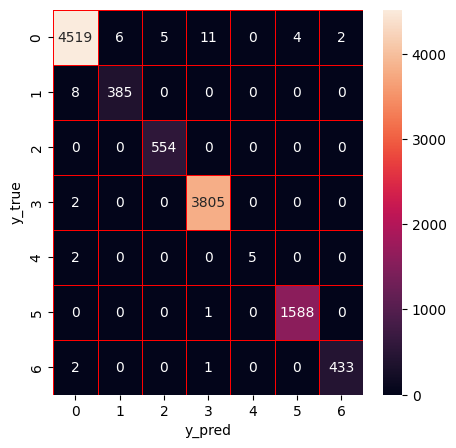

In [160]:
stk = xgb.XGBClassifier() # Stacked Model Classifier
stk.fit(x_train_resampled,y_train_resampled) # Training
stk_score = stk.score(x_test,y_test) # Evaluation on Test Data
y_predict = stk.predict(x_test) # Predict Test Data
y_true = y_test # True Labels for Test Data

print('Accuracy of STK: '+ str(stk_score)) # Accuracy of Model
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted') # Precision, Recall, and F1-score of Model
print('Precision of STK: '+(str(precision))) # Precision of the Model
print('Recall of STK: '+(str(recall))) # Recall of the Model
print('F1-score of STK: '+(str(fscore))) # F1-score of the Model

print(classification_report(y_true,y_predict)) # Classification Report of Model
cm = confusion_matrix(y_true,y_predict) # Confusion Matrix of Model
f, ax = plt.subplots(figsize=(5,5)) # Size of Confusion Matrix
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax) # Plot Confusion Matrix

plt.xlabel("y_pred") # Labels for x-axis
plt.ylabel("y_true") # Labels for y-axis
plt.show() # Shows Confusion Matrix